### Imports

In [1]:
%matplotlib notebook
import matplotlib as mpl
mpl.style.use('paper.rc')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import os, glob
from lmfit import Model, Parameter
import data_tools as dt

In [2]:
%load_ext autoreload
%autoreload 2

### Directories

In [3]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

Determined in `characterize_dot.ipynb`

In [4]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

ALPHA1_CLSD = 0.0469
ALPHA1_OPN = 0.0295
G1_OPN = 0.417
ALPHA2_CLSD = 0.0442
ALPHA2_OPN = 0.0333
G2_OPN = 0.400
ALPHA3_CLSD = 0.0415
ALPHA3_OPN = 0.0265

# Calibrate Heater

Find conversion between applied power and dT using dataset 944. Here, a DC current ($I^{DC}_{Heat}$) was used to heat the reservoir.

<IPython.core.display.Javascript object>


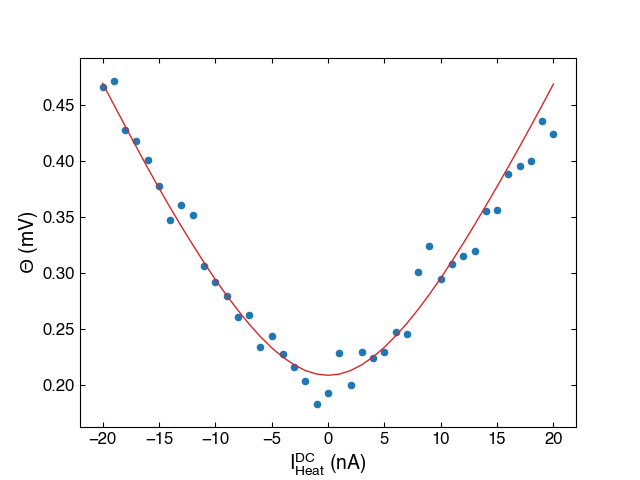

T_{base} (mK) = 113.7
\Theta (mV) = 0.2089*\sqrt{0.4988*P(pW) + 1}


In [5]:
fig, ax = plt.subplots(1,1)

dat = 944
xmult = [0.5, 1e-3*2e-8] # plunger in mV, I_AC in Amps
avgs = 5

### import i_sense ###
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense_dc2d'][:], 
                        avgs, axis=1) # rolling mean of sensor data
z = z*1e9 # i_sense (nA)
y = swp['y_array'][:]*xmult[1]*1e9 # I_AC (nA)

### fit i_sense curves ###
span = 5.0
xlim = (-490, -482)
centers = -486*np.ones(len(z))
widths = 0.6*np.ones(len(z))

i_results = dt.i_sense_fit_simultaneous(x, z, centers, 
                                        widths, xlim, constrain = None, span = span)
i_results['i_heat'] = y

### calculate DC power ###
v = swp['vdc_heat2d'][:].mean(axis=1)
v = v-v[20] # subtract offset voltage
p = (i_results['i_heat'].values*1e-9)*v*1e12 # pW
i_results['p_heat'] = p

### fit theta vs current ###
def theta_fit(x, a, b):
    return a*np.sqrt(b*x + 1)

idx = i_results['p_heat']<5.0
popt, _ = dt.curve_fit(theta_fit, i_results['p_heat'][idx], i_results['theta'][idx])
theta_calc = theta_fit(i_results['p_heat'], *popt)
t_calc = ALPHA1_CLSD*theta_calc/(K_B)
i_results['T_electron'] = t_calc

ax.scatter(i_results['i_heat'], i_results['theta'], s=20)
ax.plot(i_results['i_heat'], theta_calc, c='C3')
ax.set_xlabel(r'$I^{DC}_{Heat}$ (nA)')
ax.set_ylabel(r'$\Theta$ (mV)')

print(r'T_{{base}} (mK) = {0:.1f}'.format(ALPHA1_CLSD*popt[0]/(K_B)))
print(r'\Theta (mV) = {0:.4f}*\sqrt{{{1:.4f}*P(pW) + 1}}'.format(*popt))

np.savetxt(os.path.join(analysis_dir, "dat944_theta_calc.csv"), theta_calc, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat944_PtoTheta_fit.csv"), popt, delimiter=",")
i_results.to_csv(os.path.join(analysis_dir,'dat944_i_results.csv'), index=False) # save

In [7]:
def power_to_theta(p):
    ''' P (pW) to \theta (mV) '''
    return 0.2089*np.sqrt(0.4988*p + 1)

# Fit 0-1 peak data

Fit dI curves to fit for dS at the 0-1 electron transition. 

dataset 945 -- di vs plunger vs AC power  
dataset 1011 -- di vs plunger vs parallel field

<IPython.core.display.Javascript object>


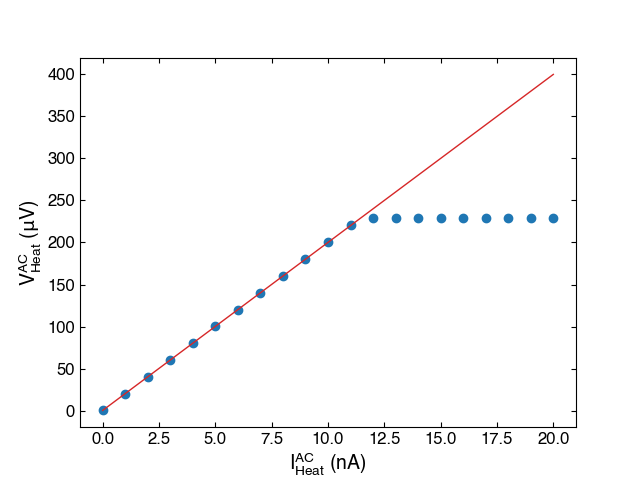

In [8]:
# calculate applied AC power
# lock in measuring v_heat overloaded, so I need to clean up the data
dat = 945
xmult = [0.5, 2e-8] # plunger in mV, I_ac in Amps

swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
v = swp['vac_heat2d'][:].mean(axis=1)*1e6
y = swp['y_array'][:]*xmult[1]*1e9

fig, ax = plt.subplots(1,1)

ax.scatter(y, v)
ax.set_xlabel('I$^{AC}_{Heat}$ (nA)')
ax.set_ylabel('V$^{AC}_{Heat}$ ($\mu V$)')

popt = np.polyfit(y[:12], v[:12], deg=1)
v_corrected = dt.line(y, *popt)
ax.plot(y, v_corrected, c='C3')

p = v_corrected*y*1e-3
t_calc = ALPHA1_CLSD*power_to_theta(p)/(K_B)

np.savetxt(os.path.join(analysis_dir, "dat945_voltage_fit.csv"), popt, delimiter=",")
di_results = pd.DataFrame({'i_heat':y, 'v_heat':v_corrected, 
                           'p_heat':p, 't_calc':t_calc, 'dT':t_calc-t_calc[0]})

In [9]:
# fit dataset 945 twice
#    first with delta=0, second with delta as a free parameter

avgs = 5
span = 5.0

x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:], avgs, axis=1)
z = z*(1e-8)*(1e9)  # convert from dV to dI (nA)

xlim = (-490, -486)
centers = -488*np.ones(len(z))
widths = 0.3*np.ones(len(z))

di_zero_params = dt.di_fit_simultaneous(x, z, centers, widths, xlim, 
                                          constrain = None, span = span, fix=['epsilon','di2'])
di_free_params, err = dt.di_fit_simultaneous(x, z, centers, widths, xlim, 
                                             constrain = None, span = span, 
                                             nboot=500, bootstat='bounds')

pd.concat([di_results, di_zero_params], axis=1).to_csv(
    os.path.join(analysis_dir,'dat945_di_zero_fits.csv'), index=False)
pd.concat([di_results, di_free_params], axis=1).to_csv(
    os.path.join(analysis_dir,'dat945_di_free_fits.csv'), index=False)
np.savetxt(os.path.join(analysis_dir, "dat945_di_free_eps-err.csv"), err, 
           delimiter=",")

In [10]:
# equation for change in entropy at 0-1 electron transition

def dS01(fields, a, b, g, de, temp):
        return dt.gibbs_entropy(fields, a, b, temp, g, de)

In [11]:
dat = 1011
xmult = [0.5, 1.0] # mV, mT
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data

avgs = 5
span = 5.0

### get centers from g_sense ###
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g_sense_dc2d'][:], avgs, axis=1)
y = swp['y_array'][:]
dz = dt.dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
centers_fit = np.polyfit(y, realmins, deg=2)
centers = dt.parabola(y,*centers_fit)

x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:], avgs, axis=1)
z = z*(1e-8)*(1e9) # nA

results = dt.di_fit_simultaneous(x, z, centers, 0.65*np.ones(len(z)), 
                                 (-495,-485), constrain = None, span=span)
results['field'] = y/1000.0

results.to_csv(os.path.join(analysis_dir,'dat1011_di_free_fits.csv'), index=False)

temp = 161.4 (mK, fixed)
peak height = 0.938 +/- 0.032
g = 0.4846 +/- 0.021
de = 0.002 +/- 0.001


<IPython.core.display.Javascript object>


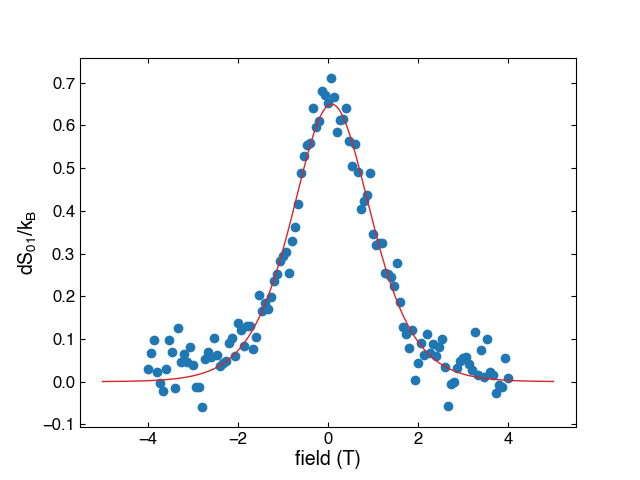

In [12]:
# create model and parameters
smodel = Model(dS01)

params = smodel.make_params()
params['a'] = Parameter(name='a', value=1.0, min=0.2, max=1.8)
params['b'] = Parameter(name='b', value=0.0, min=-0.1, max=0.1, vary=False)
params['g'] = Parameter(name='g', value=0.4, min=0.1, max=1.0)
params['de'] = Parameter(name='de', value=0.0, min=-0.1, max=0.1)

# calculate temp based on calibration above
pwr = power_to_theta(p)
current = 0.5*2e-8
volts = swp['vac_heat2d'][:].mean()
theta = power_to_theta(current*volts*1e12)
temp = theta*ALPHA1_CLSD/K_B

params['temp'] = Parameter(name='temp', value=temp, vary=False)

sresult = smodel.fit(-1.0*results['epsilon'].values, params, 
                  fields = 1000*results['field'].values)

N = 500
sfit = sresult.best_fit
resid = sresult.residual
boot_params = np.zeros((500,len(sresult.values)))
for k in range(500):
    stest = sfit + np.random.choice(resid.flatten(), size=sfit.shape)
    out = smodel.fit(stest, params, 
                      fields = 1000*results['field'].values)
    boot_params[k] = [v for k, v in out.values.items()]

### print info for paper ###
print('temp = {0:.1f} (mK, fixed)'.format(temp))

peak_err = np.abs(np.percentile(boot_params[:,0], [2.5,97.5]) - sresult.values['a']).mean()
print('peak height = {0:.3f} +/- {1:.3f}'.format(sresult.values['a'], peak_err))

g_err = np.abs(np.percentile(boot_params[:,2], [2.5,97.5]) - sresult.values['g']).mean()
print('g = {0:.4f} +/- {1:.3f}'.format(sresult.values['g'], g_err))

de_err = np.abs(np.percentile(boot_params[:,3], [2.5,97.5]) - sresult.values['de']).mean()
print('de = {0:.3f} +/- {1:.3f}'.format(sresult.values['de'], de_err))

### plot results ###
fig, ax = plt.subplots(1,1)

bs = np.linspace(-5, 5, 500)
ax.scatter(results['field'], -1.0*results['epsilon'])
ax.plot(bs, smodel.eval(sresult.params, fields=1000*bs), c='C3')
ax.set_xlabel('field (T)');
ax.set_ylabel(r'dS$_{01}$/k$_{B}$');

### save data ###
np.savetxt(os.path.join(analysis_dir, "dat1011_field.csv"), bs, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1011_dS01_fit.csv"), 
           smodel.eval(sresult.params, fields=1000*bs), delimiter=",")

# Fit 2-3 peak data

Fit dI curves to fit for dS at the 2-3 electron transition. Here, the entropy of the ST states is ignored because the field is not high enough for those states to contribute to dS

dataset 1442 -- di vs plunger vs parallel field

In [13]:
# equation for change in entropy at 0-1 electron transition

def dS23(fields, a, b, g, de, temp):
    return dt.gibbs_entropy(fields, a, b, temp, g, de)

In [14]:
dat = 1442
xmult = [0.5, 1.0] # mV, mT
n=-10
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data

avgs = 5
span = 5.0

### get centers from g_sense ###
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g_sense_dc2d'][:n], avgs, axis=1)
y = swp['y_array'][:n]
dz = dt.dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
centers_fit = np.polyfit(y, realmins, deg=2)
centers = dt.parabola(y,*centers_fit)

x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:n], avgs, axis=1)
z = z*(1e-8)*(1e9) # nA

results = dt.di_fit_simultaneous(x, -1*z, centers, 0.32*np.ones(len(z)), 
                                 (-325,-315), constrain = None, span=span)
results['field'] = y/1000.0

### save data ###
results.to_csv(os.path.join(analysis_dir,'dat1442_di_free_fits.csv'), index=False)

temp = 144.0 (mK, fixed)
peak height = 0.982 +/- 0.017
g = 0.438 +/- 0.009
de = 0.000 +/- 0.000


<IPython.core.display.Javascript object>


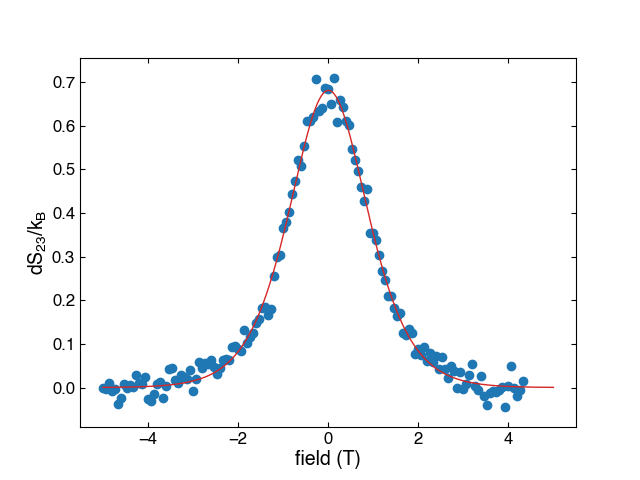

In [15]:
### create model and parameters
smodel = Model(dS23)

params = smodel.make_params()
params['a'] = Parameter(name='a', value=1.0, min=0.2, max=1.8)
params['b'] = Parameter(name='b', value=0.0, min=-0.1, max=0.1, vary=False)
params['g'] = Parameter(name='g', value=0.4, min=0.1, max=1.0)
params['de'] = Parameter(name='de', value=0.0, min=-0.1, max=0.1)

# calculate temp based on calibration above
current = 0.5*2e-8
volts = swp['vac_heat2d'][:n].mean()
theta = power_to_theta(current*volts*1e12)
temp = theta*ALPHA3_CLSD/K_B

params['temp'] = Parameter(name='temp', value=temp, vary=False)

sresult = smodel.fit(-1.0*results['epsilon'].values, params, 
                  fields = 1000*results['field'].values)

N = 500
sfit = sresult.best_fit
resid = sresult.residual
boot_params = np.zeros((500,len(sresult.values)))
for k in range(500):
    stest = sfit + np.random.choice(resid.flatten(), size=sfit.shape)
    out = smodel.fit(stest, params, 
                      fields = 1000*results['field'].values)
    boot_params[k] = [v for k, v in out.values.items()]
    
### print info for paper ###
print('temp = {0:.1f} (mK, fixed)'.format(temp))

peak_err = np.abs(np.percentile(boot_params[:,0], [2.5,97.5]) - sresult.values['a']).mean()
print('peak height = {0:.3f} +/- {1:.3f}'.format(sresult.values['a'], peak_err))

g_err = np.abs(np.percentile(boot_params[:,2], [2.5,97.5]) - sresult.values['g']).mean()
print('g = {0:.3f} +/- {1:.3f}'.format(sresult.values['g'], g_err))

de_err = np.abs(np.percentile(boot_params[:,3], [2.5,97.5]) - sresult.values['de']).mean()
print('de = {0:.3f} +/- {1:.3f}'.format(sresult.values['de'], de_err))

### plot results ###
fig, ax = plt.subplots(1,1)

bs = np.linspace(-5, 5, 500)
ax.scatter(results['field'], -1.0*results['epsilon'])
ax.plot(bs, smodel.eval(sresult.params, fields=1000*bs), c='C3')
ax.set_xlabel('field (T)');
ax.set_ylabel(r'dS$_{23}$/k$_{B}$');

### save data ###
np.savetxt(os.path.join(analysis_dir, "dat1442_field.csv"), bs, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1442_dS23_fit.csv"), 
           smodel.eval(sresult.params, fields=1000*bs), delimiter=",")

# Fit 1-2 peak data

Fit dI curves to fit for dS at the 1-2 electron transition.

dataset 1284,1285,1286,1288,1290 -- di vs plunger vs parallel field (field increases with dataset number)

In [16]:
def dS12(fields, temp, alow, ahigh, b, glow, ghigh, est, de):
    return - dt.gibbs_entropy(fields, alow, 0.0, temp, glow, de) + \
             dt.gibbs_entropy(fields, ahigh, 0.0, temp, ghigh, est) + b

In [17]:
xmult = [0.5, 1.0] # mV, mT
avgs = 5
span = 5.0

#############
dats = [1284, 1285, 1286, 1288, 1290]
ns = [None, None, 25, None, None]

columns = ['x0', 'theta', 'di0', 'di2', 'epsilon', 'field']
results = pd.DataFrame(columns=columns)

vac = []
for n, dat in zip(ns,dats):
    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    vac.append(swp['vac_heat2d'][:])
    
    ### get centers from g_sense ###
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g_sense_dc2d'][:n], avgs, axis=1)
    y = swp['y_array'][:n]
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    realmins = x[argmins]
    centers_fit = np.polyfit(y, realmins, deg=2)
    centers = dt.parabola(y,*centers_fit)

    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:n], avgs, axis=1)
    z = z*(1e-8)*(1e9) # nA

    _results = dt.di_fit_simultaneous(x, -1*z, centers, 0.32*np.ones(len(z)), 
                                            (-305,-265), constrain = None, span=span)
    _results['field'] = y/1000.0
    results = pd.concat([results, _results], ignore_index=True)

### save data ###
results.to_csv(os.path.join(analysis_dir,'dat1284-1290_di_free_fits.csv'), index=False)

temp = 153.9 (mK, fixed)
peak height (B=0) = 1.008+/-0.031
g(B=0) = 0.467+/-0.019
peak height (B=9T) = 1.043+/-0.040
g(B=9T) = 0.693+/-0.035
de = 0.000 +/- 0.001


<IPython.core.display.Javascript object>


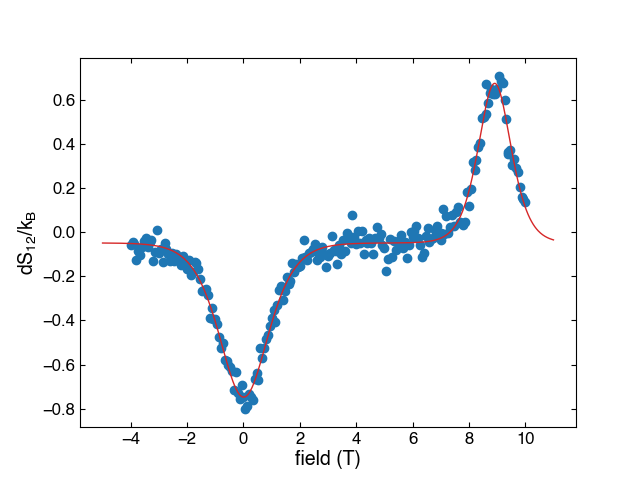

In [18]:
# create model and parameters
smodel = Model(dS12)

params = smodel.make_params()
params['alow'] = Parameter(name='alow', value=1.0, min=0.2, max=1.8)
params['ahigh'] = Parameter(name='ahigh', value=1.0, min=0.2, max=1.8)
params['glow'] = Parameter(name='glow', value=0.4, min=0.1, max=1.0)
params['ghigh'] = Parameter(name='ghigh', value=0.4, min=0.1, max=1.0)
params['est'] = Parameter(name='est', value=0.25, min=0.1, max=0.5)
params['de'] = Parameter(name='de', value=0.0, min=-0.1, max=0.1)
params['b'] = Parameter(name='b', value=0.0, min=-0.3, max=0.3)

# calculate temp based on calibration above
current = 0.5*2e-8
volts = np.nanmean(np.concatenate(vac).flatten())
theta = power_to_theta(current*volts*1e12)
temp = theta*ALPHA2_CLSD/K_B

params['temp'] = Parameter(name='temp', value=temp, vary=False)

sresult = smodel.fit(-1.0*results['epsilon'].values, params, 
                     fields = 1000*results['field'].values)

N = 500
sfit = sresult.best_fit
resid = sresult.residual
boot_params = np.zeros((500,len(sresult.values)))
for k in range(500):
    stest = sfit + np.random.choice(resid.flatten(), size=sfit.shape)
    out = smodel.fit(stest, params, 
                     fields = 1000*results['field'].values)
    boot_params[k] = [v for k, v in out.values.items()]

### print info for paper ###
# temp, alow, ahigh, b, glow, ghigh, est, de
print('temp = {0:.1f} (mK, fixed)'.format(temp))

alow_err = np.abs(np.percentile(boot_params[:,1], [2.5,97.5]) - sresult.values['alow']).mean()
print('peak height (B=0) = {0:.3f}+/-{1:.3f}'.format(sresult.values['alow'], alow_err))

glow_err = np.abs(np.percentile(boot_params[:,4], [2.5,97.5]) - sresult.values['glow']).mean()
print('g(B=0) = {0:.3f}+/-{1:.3f}'.format(sresult.values['glow'], glow_err))

ahigh_err = np.abs(np.percentile(boot_params[:,2], [2.5,97.5]) - sresult.values['ahigh']).mean()
print('peak height (B=9T) = {0:.3f}+/-{1:.3f}'.format(sresult.values['ahigh'], ahigh_err))

ghigh_err = np.abs(np.percentile(boot_params[:,5], [2.5,97.5]) - sresult.values['ghigh']).mean()
print('g(B=9T) = {0:.3f}+/-{1:.3f}'.format(sresult.values['ghigh'], ghigh_err))

de_err = np.abs(np.percentile(boot_params[:,7], [2.5,97.5]) - sresult.values['de']).mean()
print('de = {0:.3f} +/- {1:.3f}'.format(sresult.values['de'], de_err))

### plot results ###
fig, ax = plt.subplots(1,1)

bs = np.linspace(-5, 11, 800)
ax.scatter(results['field'], -1.0*results['epsilon'])
ax.plot(bs, smodel.eval(sresult.params, fields=1000*bs), c='C3')
ax.set_xlabel('field (T)');
ax.set_ylabel(r'dS$_{12}$/k$_{B}$');

### save data ###
np.savetxt(os.path.join(analysis_dir, "dat1284-1290_field.csv"), bs, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1284-1290_dS12_fit.csv"), 
           smodel.eval(sresult.params, fields=1000*bs), delimiter=",")